In [1]:
# Use the Azure Machine Learning data source package
from azureml.dataprep import datasource

# classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# modules to handle data
import pandas as pd
import numpy as np

In [2]:
# load data 
train = datasource.load_datasource('train.dsource')
test = datasource.load_datasource('test.dsource')

First Attempt at Visualizing the Data Using a Correlation Matrix

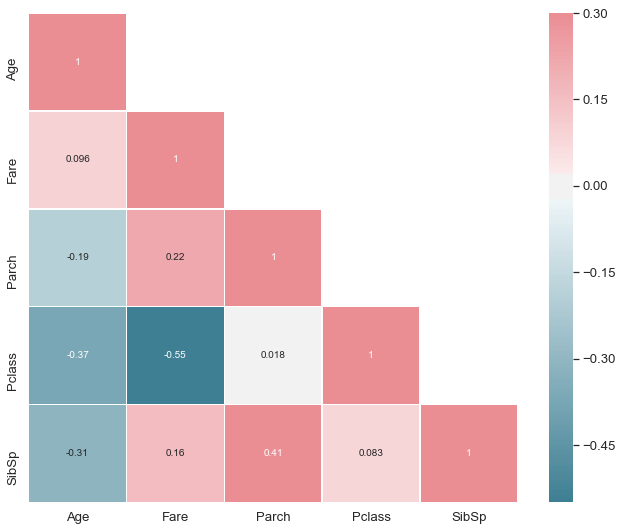

In [4]:
# matplotlib for plotting and visualization
import matplotlib.pyplot as plt 
# seaborn for data visualization
import seaborn as sns   

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# set seaborn parameters
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.rcParams['axes.color_cycle'] = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', 
                                    u'#9467bd', u'#8c564b', u'#e377c2']

%matplotlib inline

# Generate correlation matrix
corrMat = train[['Age','Cabin','Embarked','Fare','Parch','Pclass','Sex','SibSp','Ticket']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corrMat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

# Initialize matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Set custom colormap options
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation matrix as a heatmap with mask
sns.heatmap(corrMat, mask=mask, cmap=colormap, vmax=.3, annot=True,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": 1})

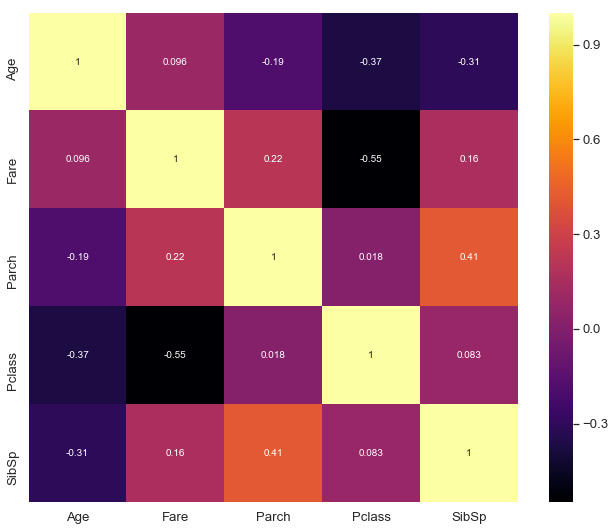

In [5]:
# Plot alternate heatmap
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(corrMat, cmap='inferno', square=True, annot=True)

Investigating Data in Order to Determine Missing Fare Values

In [13]:
# Identify missing "Fare" value
display(train[train['Fare'].isnull()])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


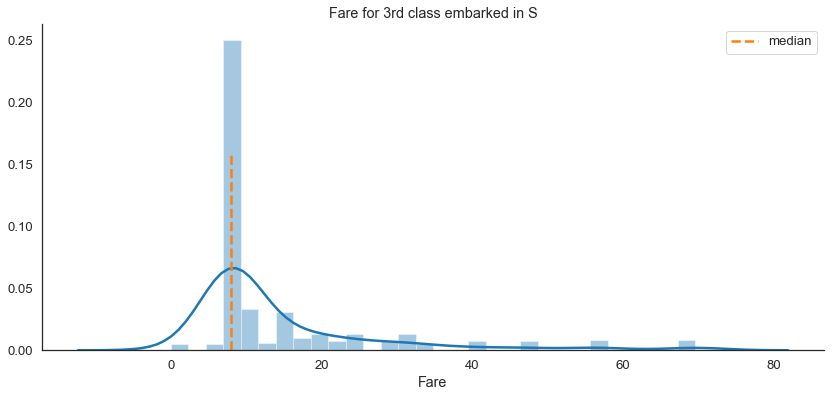

In [12]:
# Initialize the set 'Class3_EmbarkedS' which contains all 3rd class passengers who embarked from S
Class3_EmbarkedS = train['Fare'].loc[(train['Pclass']==3) & (train['Embarked']=='S')]

# Create plot of fare values for passengers in 3rd class that embarked from Southampton
# Setting parameters for plot
plt.figure(figsize=[14,6])
sns.distplot(Class3_EmbarkedS.dropna(), color='C0')
plt.plot([Class3_EmbarkedS.median(), Class3_EmbarkedS.median()], [0, 0.16], '--', color='C1')

sns.despine(bottom=0, left=0)
plt.title('Fare for 3rd class embarked in S')
plt.xlabel('Fare')
plt.legend(['median'])
plt.show()

In [ ]:
# Replace missing fares for passengers in 3rd class that embarked from Southampton
# with median fare value for those passengers
all_data['Fare'] = all_data['Fare'].fillna(Class3_EmbarkedS.median())

# Display all passengers with missing fares
# There should be no missing fares now
display(all_data[all_data['Fare'].isnull()])


#NO NEED FOR THIS

In [14]:
train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          891
Embarked       891
dtype: int64

Investigating Data in Order to Determine Missing Age Values

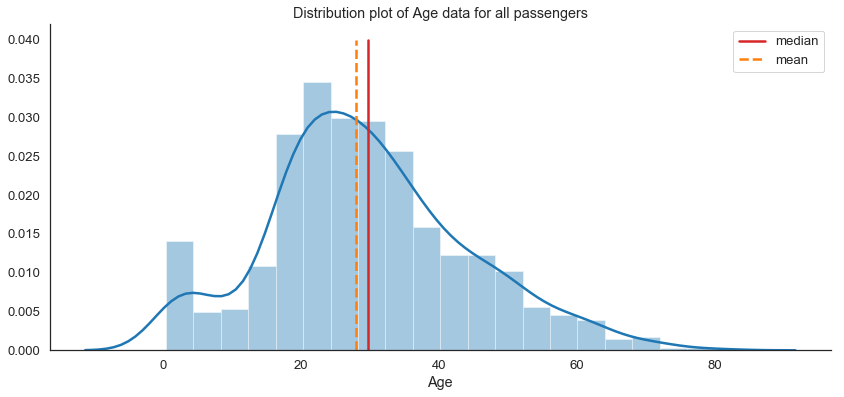

In [16]:
# Create plot of ages for all passengers
# Setting parameters for plot
plt.figure(figsize=[14,6])
sns.distplot(train['Age'].dropna(), color='C0')
plt.plot([train['Age'].mean(), train['Age'].mean()], [0, 0.04], '-', color='C3')
plt.plot([train['Age'].median(), train['Age'].median()], [0, 0.04], '--', color='C1')

sns.despine(bottom=0, left=0)
plt.title('Distribution plot of Age data for all passengers')
plt.xlabel('Age')
plt.legend(['median', 'mean'])
plt.show()

In [18]:
# Initialize the set 'Class1_EmbarkedQ' which contains the data for all 1st class passengers who embarked from Queenstown
Age_LessThan_18 = train.loc[(train['Age']<18)]
Age_LessThan_18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 7 to 875
Data columns (total 12 columns):
PassengerId    113 non-null float64
Survived       113 non-null float64
Pclass         113 non-null float64
Name           113 non-null object
Sex            113 non-null object
Age            113 non-null float64
SibSp          113 non-null float64
Parch          113 non-null float64
Ticket         113 non-null object
Fare           113 non-null float64
Cabin          113 non-null object
Embarked       113 non-null object
dtypes: float64(7), object(5)
memory usage: 11.5+ KB


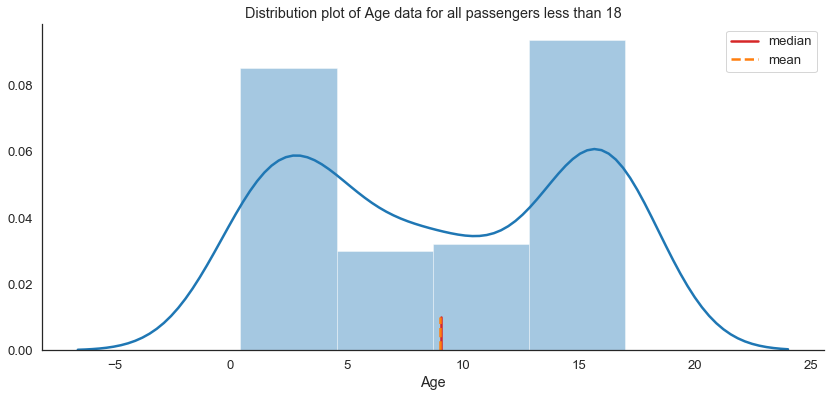

In [19]:
# Create plot of fare values for passengers in first class that embarked from Queenstown
# Setting parameters for plot
plt.figure(figsize=[14,6])
sns.distplot(Age_LessThan_18['Age'].dropna(), color='C0')
plt.plot([Age_LessThan_18['Age'].mean(), Age_LessThan_18['Age'].mean()], [0, 0.01], '-', color='C3')
plt.plot([Age_LessThan_18['Age'].median(), Age_LessThan_18['Age'].median()], [0, 0.01], '--', color='C1')

sns.despine(bottom=0, left=0)
plt.title('Distribution plot of Age data for all passengers less than 18')
plt.xlabel('Age')
plt.legend(['median', 'mean'])
plt.show()

In [21]:
all_data = train

In [22]:
# Clean up and feature engineering

# Label Survived for plot
all_data['Survived'] = all_data['Survived'].replace([0, 1], ['no', 'yes'])

# Label Sex for plot
all_data['Sex'] = all_data['Sex'].replace([0, 1], ['male', 'female'])

# Transform Fare to today's US dollar, for fun
all_data['Fare'] = all_data['Fare']*108*1.3 #historic gbp to current gbp to current usd

In [23]:
# Get personal title from Name, merge rare titles
all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split(' ')[1])
toreplace = ['Jonkheer.', 'Ms.', 'Mlle.', 'Mme.', 'Capt.', 'Don.', 'Major.',
             'Col.', 'Sir.', 'Dona.', 'Lady.', 'the']
replacewith = ['Master.', 'Miss.', 'Miss.', 'Mrs.', 'Sir.', 'Sir.', 'Sir.',
              'Sir.', 'Sir.', 'Lady.', 'Lady.', 'Lady.']
all_data['Title'] = all_data['Title'].replace(toreplace, replacewith)

In [24]:
# Get family names
all_data['FamName'] = all_data['Name'].apply(lambda x: x.split(',')[0])

# Get family sizes based on Parch and SibSp, classify as single/small/large
all_data['FamSize'] = all_data['Parch'] + all_data['SibSp'] + 1
all_data['FamSize2'] = pd.cut(all_data['FamSize'], [0, 1, 4, 11], labels=['single', 'small', 'large'])

In [25]:
# Get group sizes based on Ticket, classify as single/small/large
all_data['GrpSize'] = all_data['Ticket'].replace(all_data['Ticket'].value_counts())
all_data['GrpSize2'] = pd.cut(all_data['GrpSize'], [0, 1, 4, 11], labels=['single', 'small', 'large'])

In [ ]:
#WISHFUL THINKING - MAYBE

# Get Deck from Cabin letter
def getdeck(cabin):
    if not pd.isnull(cabin) and cabin[0] in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        return cabin[0]
    else:
        return 'X'

all_data['Deck'] = all_data['Cabin'].apply(getdeck)

# Get a rough front/mid/back location on the ship based on Cabin number
'''
A front
B until B49 is front, rest mid
C until C46 is front, rest mid
D until D50 is front, rest back
E until E27 is front, until E76 mid, rest back
F back
G back
Source: encyclopedia-titanica.org/titanic-deckplans/
'''
def getfmb(cabin):

    if not pd.isnull(cabin) and len(cabin)>1:
        if (cabin[0]=='A'
            or cabin[0]=='B' and int(cabin[1:4])<=49
            or cabin[0]=='C' and int(cabin[1:4])<=46
            or cabin[0]=='D' and int(cabin[1:4])<=50
            or cabin[0]=='E' and int(cabin[1:4])<=27):
            return 'front'

        elif (cabin[0]=='B' and int(cabin[1:4])>49
            or cabin[0]=='C' and int(cabin[1:4])>46
            or cabin[0]=='E' and int(cabin[1:4])>27 and int(cabin[1:4])<=76):
            return 'mid'

        elif (cabin[0]=='F'
           or cabin[0]=='G'
           or cabin[0]=='D' and int(cabin[1:4])>50):
            return 'back'

        else:
            return 'unknown'
    else:
        return 'unknown'

all_data['CabinLoc'] = all_data['Cabin'].apply(getfmb)


In [29]:
all_data['Cabin']

0                 
1              C85
2                 
3             C123
4                 
5                 
6              E46
7                 
8                 
9                 
10              G6
11            C103
12                
13                
14                
15                
16                
17                
18                
19                
20                
21             D56
22                
23              A6
24                
25                
26                
27     C23 C25 C27
28                
29                
          ...     
861               
862            D17
863               
864               
865               
866               
867            A24
868               
869               
870               
871            D35
872    B51 B53 B55
873               
874               
875               
876               
877               
878               
879            C50
880               
881               
882         

In [33]:
#all_data['CabinLoc'] = all_data['CabinLoc'].replace(['unknown', 'front', 'mid', 'back'], range(4))
#all_data['Deck'] = all_data['Deck'].replace(['X', 'A', 'B', 'C', 'D', 'E', 'F', 'G'], range(8))

all_data['GrpSize2'] = all_data['GrpSize2'].astype(str) #convert from category dtype
all_data['GrpSize2'] = all_data['GrpSize2'].replace(['single', 'small', 'large'], range(3))

all_data['FamSize2'] = all_data['FamSize2'].astype(str) #convert from category dtype
all_data['FamSize2'] = all_data['FamSize2'].replace(['single', 'small', 'large'], range(3))

all_data['Title'] = all_data['Title'].replace(all_data['Title'].unique(), range(8))

all_data['Embarked'] = all_data['Embarked'].replace(['S', 'C', 'Q'], range(3))

all_data['Sex'] = all_data['Sex'].replace(['male', 'female'], range(2)) 

all_data['Survived'] = all_data['Survived'].replace(['no', 'yes'], range(2)) 


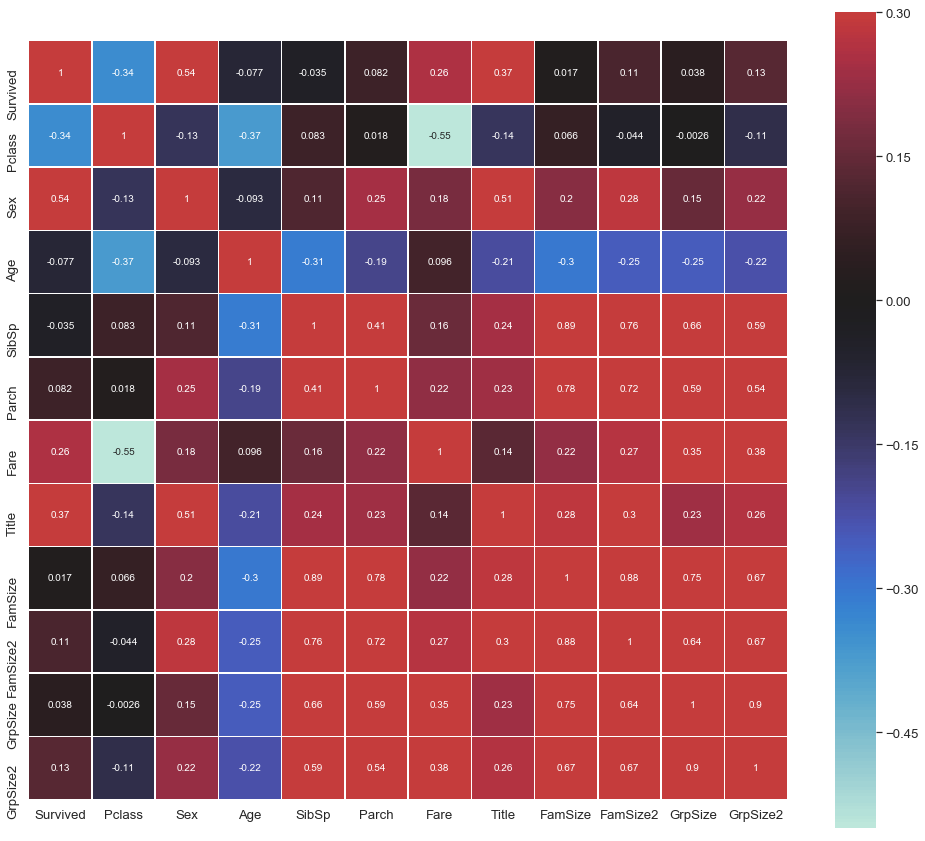

In [36]:
# Plot updated correlation matrix
corrMat = all_data[['Age','Cabin','Embarked','Fare','Parch','Pclass','Sex','SibSp','Ticket']].corr()
corrMat = all_data.drop(['PassengerId'], axis = 1).corr()

# Initialize matplotlib figure
f, ax = plt.subplots(figsize=(17,15))

# Set custom colormap options
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation matrix as a heatmap with mask
sns.heatmap(corrMat, vmax=.3, annot=True,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": 1})

In [38]:
# Still need to perform linear regression to predict missing age values (maybe... current classification is looking decent)
# ----- Configure data for survival classification using neural network -----
age_class_data = all_data[['Age','Embarked','Fare','Parch','Pclass','Sex','SibSp','Survived']]

In [41]:
# Split data into training and testing sets
age_data_training = age_class_data[age_class_data['Age'].notnull()]
age_data_testing = age_class_data[age_class_data['Age'].isnull()]

In [42]:
# View info on training and testing sets
print("------ Training Data Information ------")
age_data_training.info()

print("\n\n------ Testing Data Information ------")
age_data_testing.info()

------ Training Data Information ------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 8 columns):
Age         714 non-null float64
Embarked    714 non-null object
Fare        714 non-null float64
Parch       714 non-null float64
Pclass      714 non-null float64
Sex         714 non-null int64
SibSp       714 non-null float64
Survived    714 non-null int64
dtypes: float64(5), int64(2), object(1)
memory usage: 50.2+ KB


------ Testing Data Information ------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 5 to 888
Data columns (total 8 columns):
Age         0 non-null float64
Embarked    177 non-null object
Fare        177 non-null float64
Parch       177 non-null float64
Pclass      177 non-null float64
Sex         177 non-null int64
SibSp       177 non-null float64
Survived    177 non-null int64
dtypes: float64(5), int64(2), object(1)
memory usage: 12.4+ KB


In [43]:
# ----- Format input and target data for age classification as numpy matrices -----
# Create numpy matricies for training data
X_train_age = age_data_training.iloc[:, 1:7].values
#age_data_training.iloc[:, 1:7].info()  # Code for viewing info about data used in matrix
Y_train_age = age_data_training[['Survived']].values
#age_data_training[['Age']].info()  # Code for viewing info about data used in matrix
# Confirming that the shape of the training matrices are correct
print("\n\nShape of X_train: ", X_train_age.shape)
print("Shape of Y_train: ", Y_train_age.shape)

# Create numpy matricies for testing data
X_test_age = age_data_testing.iloc[:, 1:7].values
#age_data_training.iloc[:, 1:7].info()  # Code for viewing info about data used in matrix
Y_test_age = age_data_testing[['Age']].values



Shape of X_train:  (714, 6)
Shape of Y_train:  (714, 1)


In [47]:
# ----- Configure data for survival classification using neural network -----
survival_class_data = all_data.drop(['PassengerId','Cabin','Name','Ticket','FamName','Age'], axis = 1)
print("----- Information on Data for Survival Classification -----")
survival_class_data.info()
#display(survival_class_data[survival_class_data['Age'].isnull()])

# Split data into training and testing sets for cross validation
survival_train_data, survival_test_data = train_test_split(survival_class_data, test_size=0.2)

# View info on training and testing sets
print("------ Training Data Information ------")
survival_train_data.info()

print("\n\n------ Testing Data Information ------")
survival_test_data.info()

# ----- Format input and target data for age classification as numpy matrices -----
# Create numpy matricies for training data
X_train = survival_train_data.drop(['Survived'], axis=1).values
Y_train = survival_train_data[['Survived']].values

# Confirming that the shape of the training matrices are correct
print("\n\nShape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)

# Create numpy matricies for testing data
X_test = survival_test_data.drop(['Survived'], axis=1).values
Y_test = survival_test_data[['Survived']].values

# Confirming that the shape of the testing matrices are correct
print("\n\nShape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

----- Information on Data for Survival Classification -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived    891 non-null int64
Pclass      891 non-null float64
Sex         891 non-null int64
SibSp       891 non-null float64
Parch       891 non-null float64
Fare        891 non-null float64
Embarked    891 non-null object
Title       891 non-null int64
FamSize     891 non-null float64
FamSize2    891 non-null int64
GrpSize     891 non-null int64
GrpSize2    891 non-null int64
dtypes: float64(5), int64(6), object(1)
memory usage: 83.6+ KB
------ Training Data Information ------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 169 to 162
Data columns (total 12 columns):
Survived    712 non-null int64
Pclass      712 non-null float64
Sex         712 non-null int64
SibSp       712 non-null float64
Parch       712 non-null float64
Fare        712 non-null float64
Embarked    712 non-null object
Title       712 

In [50]:
!pip install keras

You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [51]:
# keras for machine learning tools
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [56]:
# Create sequential model for neural network
nnet_model = Sequential()

# ----- Add first layer of network (Input layer) -----
# Number of neurons:   15
# Number of inputs:    11 (the features Embarked, Fare, Parch, Pclass, Sex, SibSp)
# Activation layer:  ReLU (Rectified Linear Unit)
# 'Dense' refers to the fact that the layer is totally connected
nnet_model.add(Dense(15, input_dim=11, activation='relu'))

# ----- Add second layer of network (Hidden layer) -----
# Number of neurons:    8
# Number of inputs:    15 (this is automatically determined since the model type is 'Sequential')
# Activation layer:  ReLU (Rectified Linear Unit)
nnet_model.add(Dense(8, activation='tanh'))

# ----- Add final layer of network (Output layer) -----
# Number of neurons:       1
# Number of inputs:       18 (this is automatically determined since the model type is 'Sequential')
# Activation layer:  Sigmoid (This ensures out output is between 0 and 1 for classification)
nnet_model.add(Dense(1, activation='sigmoid'))

In [57]:
# Compile the neural network model
# Loss function:      Logarithmic loss
# Gradient Descent algorithm:     adam (More on adam here: https://arxiv.org/abs/1412.6980)
# Classification metric:      accuracy
nnet_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
# WISHFUL THINKING

# Fit the model using the training data
nnet_model.reset_states()
nnet_model.fit(X_train, Y_train, epochs=5, batch_size=10)

# Evaluate the now trained model on the data set aside for cross validation
nnet_scores = nnet_model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (nnet_model.metrics_names[1], nnet_scores[1]*100))

# Alternatively, observe what happens when we normalize our input data beforehand
# ----- Normalize input data in matrices for training and testing sets -----
# Quick breakdown of what each part of the update is doing:
# X_train.min(0) : Array whose ith component is the minimum of the ith component of X_train taken over all rows of X_train
# X_train.ptp(0) : Array whose ith component is the 'peak to peak' value of the ith component of X_train (i.e., X_train.max(0) - X_train.min(0))
X_train = (X_train - X_train.min(0)) / X_train.ptp(0)
X_test = (X_test - X_test.min(0)) / X_test.ptp(0)

# Reset all of the states in the model
nnet_model.reset_states()

# Fit the model using the training data
nnet_model.fit(X_train, Y_train, epochs=5, batch_size=10)

# Evaluate the now trained model on the data set aside for cross validation
nnet_scores = nnet_model.evaluate(X_test, Y_test)

# Print the accuracy for the testing data
print("\n%s: %.2f%%" % (nnet_model.metrics_names[1], nnet_scores[1]*100))

# Print the testing data so we can see the predicitions for who survived
survival_prediction_data = survival_test_data.copy()

# Compute predictions
predictions = nnet_model.predict(X_test)

# Round predictions
predictions = np.round(predictions)

# Add survival predictions to data set
for i in range(179):
    survival_prediction_data['Survived'][i] = predictions[i]

# Display data set information
display(survival_prediction_data)
